## Hospital Length of stay using LightGBM  Model & Tranformer Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
#from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv


In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("covid/10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("covid/10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients.DEATHDATE.fillna("2021-01-01", inplace = True) 
patients.DEATHDATE = pd.to_datetime(patients["DEATHDATE"])
patients.BIRTHDATE =  pd.to_datetime(patients["BIRTHDATE"])
patients["age"] =patients.DEATHDATE- patients.BIRTHDATE
patients['age'] = patients.age.astype('timedelta64[Y]').astype('int')
patients["healthcare_coverage_ratio"] = patients.HEALTHCARE_COVERAGE / patients.HEALTHCARE_EXPENSES
patients = patients[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
patients = patients.rename(columns = {"Id": "patient"})

In [6]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    data = data.rename(columns = {"Id": "patient"})
    return data

In [7]:
patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [8]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [9]:
# Careplan

careplan_df = pd.read_csv("covid/100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [10]:

careplan_df = pd.merge(careplan_df, patients,  on='patient', how = "left")

careplan_df_test = pd.merge(careplan_df_test, patients_test,  on='patient', how = "left")

In [11]:
#Conditions

conditions_df = pd.read_csv("covid/100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [12]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [13]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [14]:
medications_df = pd.read_csv("covid/100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [15]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [16]:
#Observations

observations_df = pd.read_csv("covid/100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [17]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [18]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [19]:
observations_df.head()

,patient,patient's_observation_of_Respiratory_rate,patient's_observation_of_Heart_rate,patient's_observation_of_Body_Weight,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma,...,patient's_observation_of_Eosinophils_volume_in_Blood_by_Automated_count,patient's_observation_of_Leukocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_MCV_Entitic_volume_by_Automated_count,patient's_observation_of_Chloride_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Creatinine_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Urea_nitrogen_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Neutrophils100_leukocytes_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
7710130,dd641115-8ce8-483f-9e7f-66859b5da808,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2.9,0,0,Creatinine_Massvolume_in_Serum_or_Plasma,3,3
6513225,da506f9a-2e51-40a2-b26c-e6d9ab9c545c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Monocytes_volume_in_Blood_by_Automated_count,2,2
14871168,b11bff49-70d4-460c-91fd-242129f4681d,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16.9,0,Urea_nitrogen_Massvolume_in_Serum_or_Plasma,1,1
414952,9b4fee7c-2d93-417c-9ccd-7e1f1a15af7b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Troponin_Icardiac_Massvolume_in_Serum_or_Plasm...,1,1
6792629,beb22bb2-caff-43b5-a1b3-f42517851df2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Adenovirus_ABCDE_DNA_Presence_in_Respiratory_s...,1,1


In [20]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [21]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [22]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [23]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [24]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [25]:
encounters = pd.read_csv("covid/100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("covid/10k_synthea_covid19_csv/encounters.csv")


In [26]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [27]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [28]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [29]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [30]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [31]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [32]:
def merger(data1, data2, data3, data4,data5, data6, data7, data8, join_keys, goal):
    merged_df = pd.merge(data1, data2, on = join_keys)
    merged_df = pd.merge(merged_df, data3, on = join_keys)
    merged_df = pd.merge(merged_df, data4, on = join_keys)
    return merged_df
    

In [33]:
merged_train= pd.merge(careplan_df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")


In [34]:
merged_train.columns

Index(['patient', 'careplan_start', 'careplan_end', 'careplan_desc',
       'careplan_reason', 'Infectious disease care plan record artifact',
       'Diabetes self management plan',
       'Lifestyle education regarding hypertension',
       'Self-care interventions procedure', 'Respiratory therapy',
       ...
       'patient's_alergy_of_Allergy to grass pollen',
       'patient's_alergy_of_Allergy to tree pollen',
       'patient's_alergy_of_House dust mite allergy',
       'patient's_alergy_of_Shellfish allergy',
       'patient's_alergy_of_Allergy to bee venom',
       'patient's_alergy_of_Allergy to peanuts',
       'patient's_alergy_of_Allergy to fish',
       'patient's_alergy_of_Allergy to nut', 'patient's most seen allergy',
       'doctor_count_per_city'],
      dtype='object', length=172)

In [35]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6416 entries, 0 to 6415
Columns: 172 entries, patient to doctor_count_per_city
dtypes: float64(111), int64(7), object(54)
memory usage: 8.5+ MB


In [36]:
merged_test= pd.merge(careplan_df_test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")


In [37]:
#merged_test= pd.merge(careplan_df, conditions_df, on = ["patient"])
#merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])

In [38]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "total_med_duration_of_patient"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "total_med_duration_of_patient"]).reset_index(drop = True)

In [39]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True)

In [40]:
## let's convert our date objects into datetime objects for further usage

data.careplan_end = pd.to_datetime(data.careplan_end)
data.careplan_start = pd.to_datetime(data.careplan_start)

In [41]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 2420 unique patients.


In [42]:
data.fillna(0, inplace = True)

In [43]:
data = data.drop([ "careplan_desc", "careplan_reason"], 1)

In [44]:
data.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city
0,2252343c-ebeb-46c9-8dc4-5ff972b7cf16,2020-03-06,2020-03-25 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
1,f9a3c224-30f6-42c0-ae5b-d1190ab83495,2020-03-12,2020-04-01 00:00:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,ff729ead-a4f6-4d88-93ae-52dae4ba902c,2020-03-04,2020-04-04 00:00:00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,c20ca401-dd8e-453c-ace4-9b56a1dbb268,2020-03-07,2020-04-04 00:00:00,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
4,a871223c-3cb7-46aa-abb6-f804813efb71,2020-02-25,2020-03-11 00:00:00,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [45]:
df = data.copy()
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city
0,2252343c-ebeb-46c9-8dc4-5ff972b7cf16,2020-03-06,2020-03-25 00:00:00,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
1,f9a3c224-30f6-42c0-ae5b-d1190ab83495,2020-03-12,2020-04-01 00:00:00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,ff729ead-a4f6-4d88-93ae-52dae4ba902c,2020-03-04,2020-04-04 00:00:00,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,c20ca401-dd8e-453c-ace4-9b56a1dbb268,2020-03-07,2020-04-04 00:00:00,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
4,a871223c-3cb7-46aa-abb6-f804813efb71,2020-02-25,2020-03-11 00:00:00,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


### Let's create our target feature, careplan duration


In [46]:
df = df.sort_values("careplan_start")
df.careplan_end = pd.to_datetime(df.careplan_end, format='%Y-%m-%d', errors='coerce')
df.careplan_start = pd.to_datetime(df.careplan_start, format='%Y-%m-%d', errors='coerce')
df["careplan_duration"] = (df.careplan_end - df.careplan_start).dt.days
df = df.reset_index(drop = True)
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,careplan_duration
0,43d406c5-8c6d-46d0-b957-1fc20a6e641c,2020-01-24,2020-02-15,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,22.0
1,0d38471f-d675-4957-8413-603b34f9f207,2020-01-26,2020-02-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,34.0
2,8440e987-fa25-4355-b109-5001dbb92704,2020-02-01,2020-02-21,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,20.0
3,967ebd40-f62b-4b2b-98b4-5b6d10325c2e,2020-02-03,2020-03-10,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,36.0
4,a805049f-89c8-4cf0-b432-5971a63c84ef,2020-02-04,2020-02-21,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,17.0


In [47]:
#Create time features

df["start_month"] = df.careplan_start.dt.month
df["start_day"] = df.careplan_start.dt.day_of_year
df["start_week"] = df.careplan_start.dt.day_of_week
df["start_year"] = df.careplan_start.dt.year

In [48]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [49]:
df.head()

,patient,careplan_start,careplan_end,Infectious disease care plan record artifact,Diabetes self management plan,Lifestyle education regarding hypertension,Self-care interventions procedure,Respiratory therapy,Musculoskeletal care,Hyperlipidemia clinical management plan,...,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,careplan_duration,start_month,start_day,start_week,start_year
0,43d406c5-8c6d-46d0-b957-1fc20a6e641c,2020-01-24,2020-02-15,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0.0,22.0,1,24,4,2020
1,0d38471f-d675-4957-8413-603b34f9f207,2020-01-26,2020-02-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.0,34.0,1,26,6,2020
2,8440e987-fa25-4355-b109-5001dbb92704,2020-02-01,2020-02-21,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0,0.0,20.0,2,32,5,2020
3,967ebd40-f62b-4b2b-98b4-5b6d10325c2e,2020-02-03,2020-03-10,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0,0.0,36.0,2,34,0,2020
4,a805049f-89c8-4cf0-b432-5971a63c84ef,2020-02-04,2020-02-21,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0,0.0,17.0,2,35,1,2020


In [50]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [51]:
"""nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)"""

'nums = df.select_dtypes(include=np.number).columns.tolist()\nNUMERIC_FEATURES = []\nfor i in nums:\n  if i not in ["careplan_duration", "duration", "CODE"]:\n    NUMERIC_FEATURES.append(i)'

In [52]:
"""cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)"""

'cats = df.select_dtypes(exclude=np.number).columns.tolist()\nCATEGORICAL_FEATURES = []\nfor i in cats:\n  if i not in ["patient", "careplan_start", "careplan_end", "dataset", "START", "STOP", "ENCOUNTER"]:\n    CATEGORICAL_FEATURES.append(i)'

In [53]:
NUMERIC_FEATURES = ['age', 
 'healthcare_coverage_ratio',
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Sore throat symptom finding",
 "patient's_condition_of_Headache finding",
 "patient's_condition_of_Chill finding",
 "patient's_condition_of_Diabetes",
 'patient_condition_count',
 'patient_condition_unique',
 'patient_obs_count',
 'patient_obs_count_unique',
 'total_med_duration_of_patient',
 'total_med_cost_of_patient',
 'total_med_count_of_patient',
 'total_unique_med_of_patient',
 'used_unique_device_per_patient',
 'Mechanical ventilator (physical object)',
 'unique_immunizations',
 "patient's Digital Radiographycount",
 "patient's Ultrasoundcount",
 "patient's_different_bodysite_imaging_studies",
 'unique_allergies_per_patient']

In [79]:
CATEGORICAL_FEATURES = ["patient's most seen careplan",
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Glucose_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's most seen observation",
 "patient's most used medication",
 "patient's most used device",
 "patient's most seen allergy"]

In [80]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### About real distributions of hospital durations?

### LightGBM

In [81]:
df.columns

Index(['patient', 'careplan_start', 'careplan_end',
       'Infectious disease care plan record artifact',
       'Diabetes self management plan',
       'Lifestyle education regarding hypertension',
       'Self-care interventions procedure', 'Respiratory therapy',
       'Musculoskeletal care', 'Hyperlipidemia clinical management plan',
       ...
       'patient's_alergy_of_Allergy to peanuts',
       'patient's_alergy_of_Allergy to fish',
       'patient's_alergy_of_Allergy to nut', 'patient's most seen allergy',
       'doctor_count_per_city', 'careplan_duration', 'start_month',
       'start_day', 'start_week', 'start_year'],
      dtype='object', length=175)

In [82]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")

In [83]:
train = df.loc[(df.dataset == "train") & (df.careplan_duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())]

In [84]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### Train & Validation 

In [85]:
from sklearn.model_selection import train_test_split
X = train.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1)
y = train.careplan_duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)


In [86]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

3.5745222420256777

In [87]:
CATEGORICAL_FEATURES

["patient's most seen careplan",
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Glucose_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's most seen observation",
 "patient's most used medication",
 "patient's most used device",
 "patient's most seen allergy"]

In [88]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1))
lgb_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_mae = mae(test.careplan_duration, real_preds)
lgb_r2 = r2_score(test.careplan_duration, real_preds)



In [89]:
lgb_r2

0.733173408512372

### Parameter Optimization

In [90]:
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }

In [91]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
param_comb = 6

kf = StratifiedKFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f14c38715f0>,
                   estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.99],
                                        'max_depth': [3, 4, 5, 6, 7, 10],
                                        'min_child_weight': [1, 5, 10, 15],
                                        'num_iterations': [100, 500, 1000],
                                        'num_leaves': [4, 8, 16, 32, 64, 80],
                                        'reg_lambda': [0.2, 0.5, 1, 1.5]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [92]:
print(random_search.best_params_)

{'reg_lambda': 1, 'num_leaves': 16, 'num_iterations': 500, 'min_child_weight': 5, 'max_depth': 6, 'colsample_bytree': 0.99}


In [93]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2

3.710116586327928

##Test

In [94]:
model.fit(X, y)

real_preds = model.predict(test.drop(["careplan_duration",  "START", "STOP", "ENCOUNTER","dataset", "careplan_start", "careplan_end", "patient"],1))
lgb_tuned_rmse = mean_squared_error(test.careplan_duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.careplan_duration, real_preds)
lgb_tuned_r2 = r2_score(test.careplan_duration, real_preds)



In [95]:
results = pd.DataFrame(test.careplan_duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()

Text(0, 0.5, '% difference between real values and predictions')

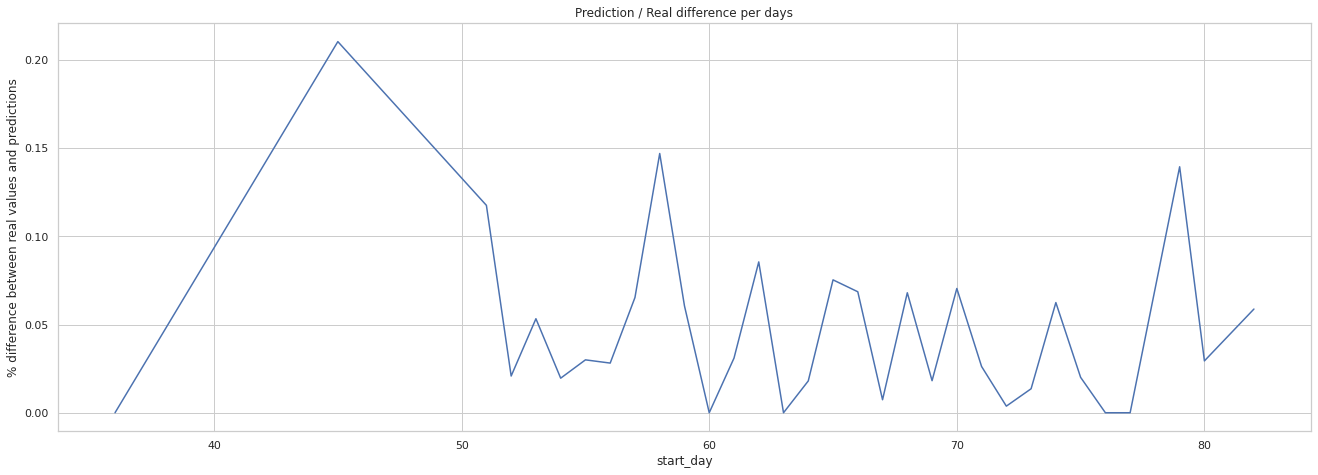

In [96]:
test["preds"] = a.preds.values
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["careplan_duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

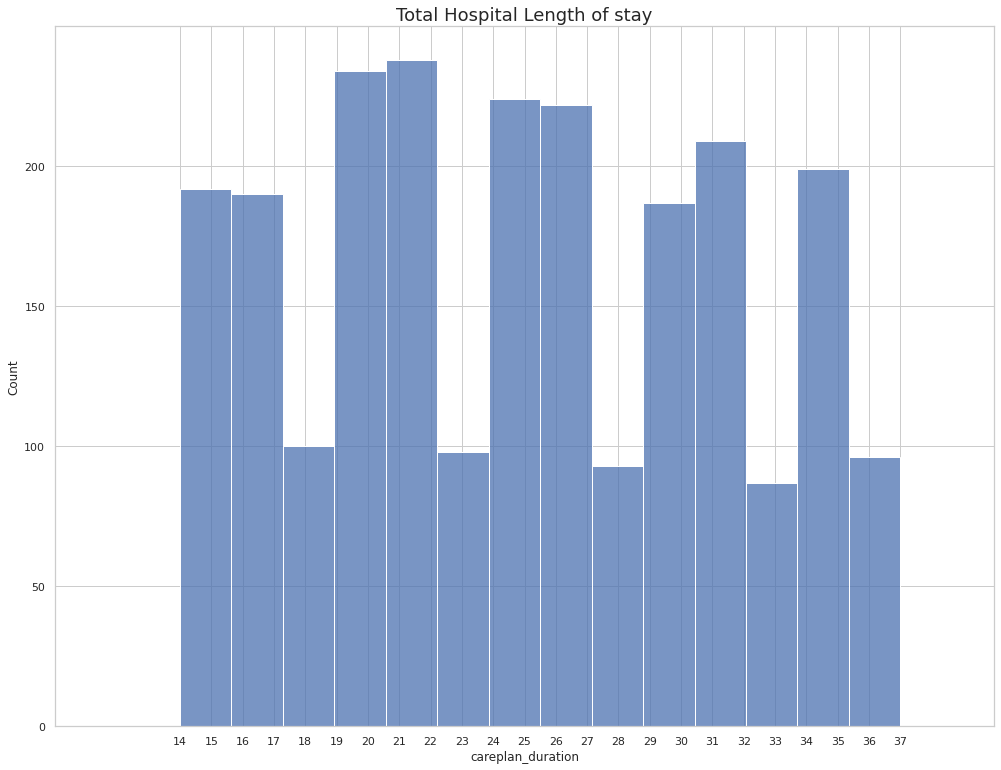

In [97]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "careplan_duration")
plt.xticks(np.arange(14,38,1))
plt.xlim(10,40)
plt.title('Total Hospital Length of stay', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

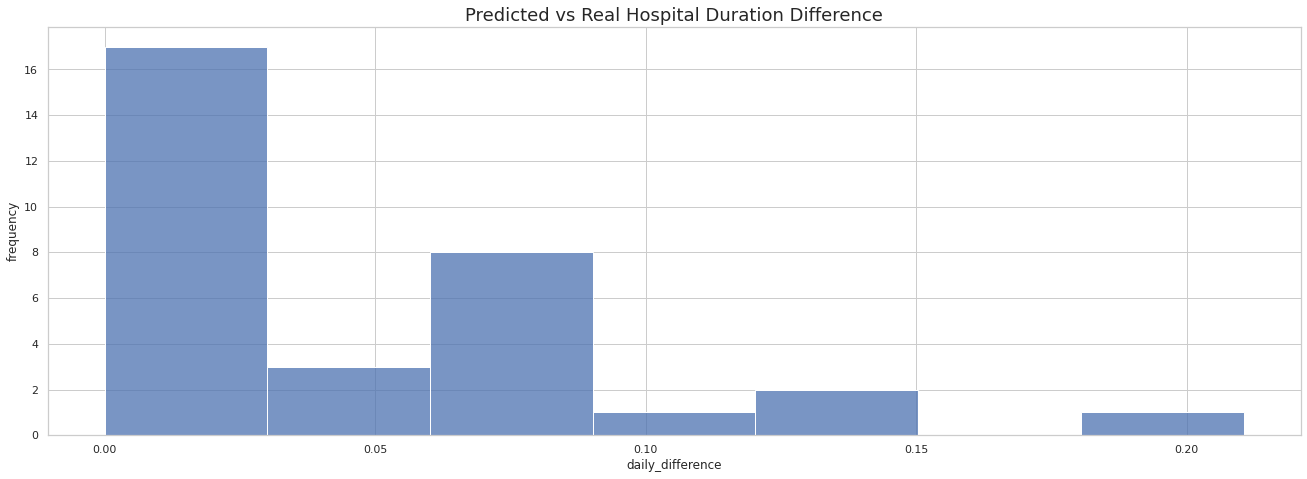

In [98]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real Hospital Duration Difference", fontsize = 18)
plt.ylabel("frequency")

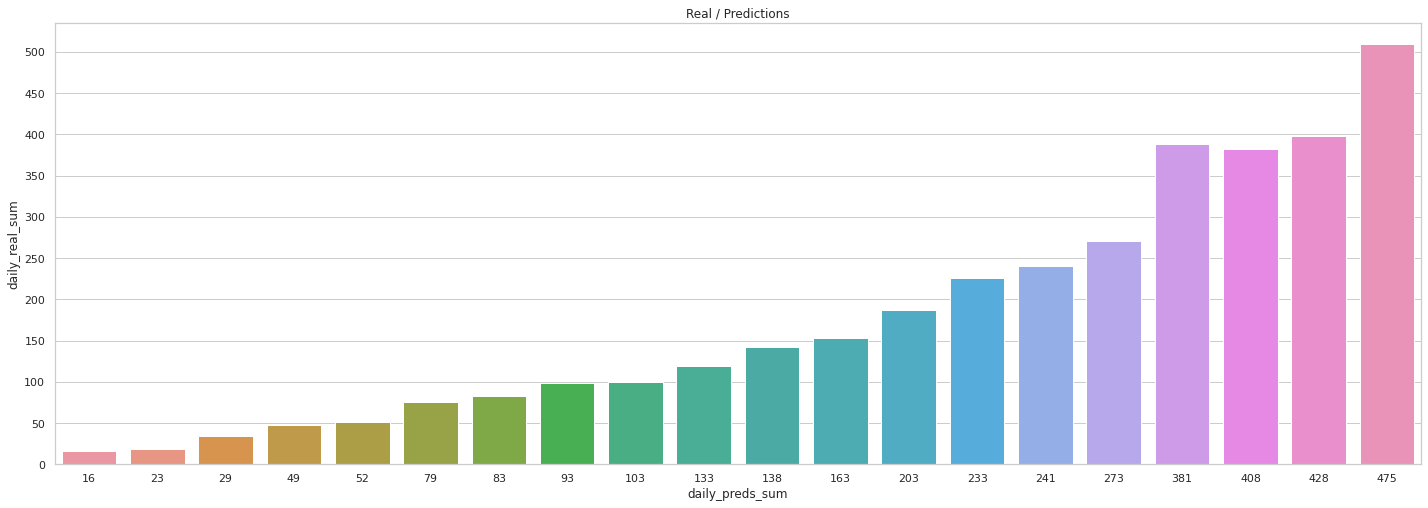

In [99]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

In [100]:
np.std([test.preds, test.careplan_duration])

6.112285314653769

Text(0.5, 1.0, 'Daily differences between real values and predictions')

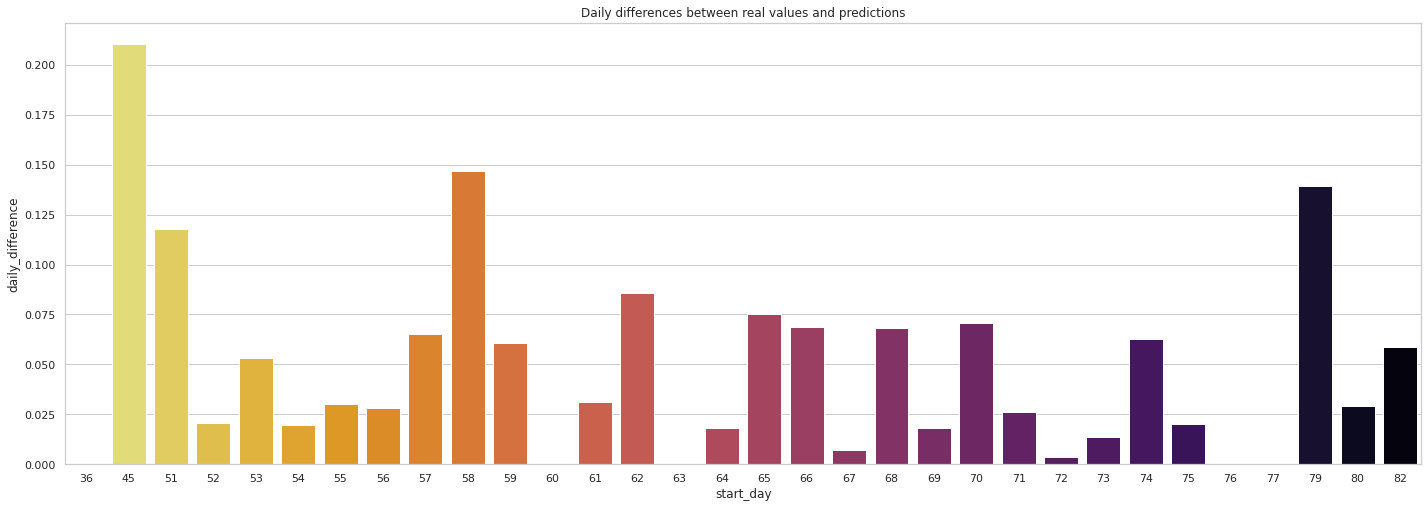

In [101]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

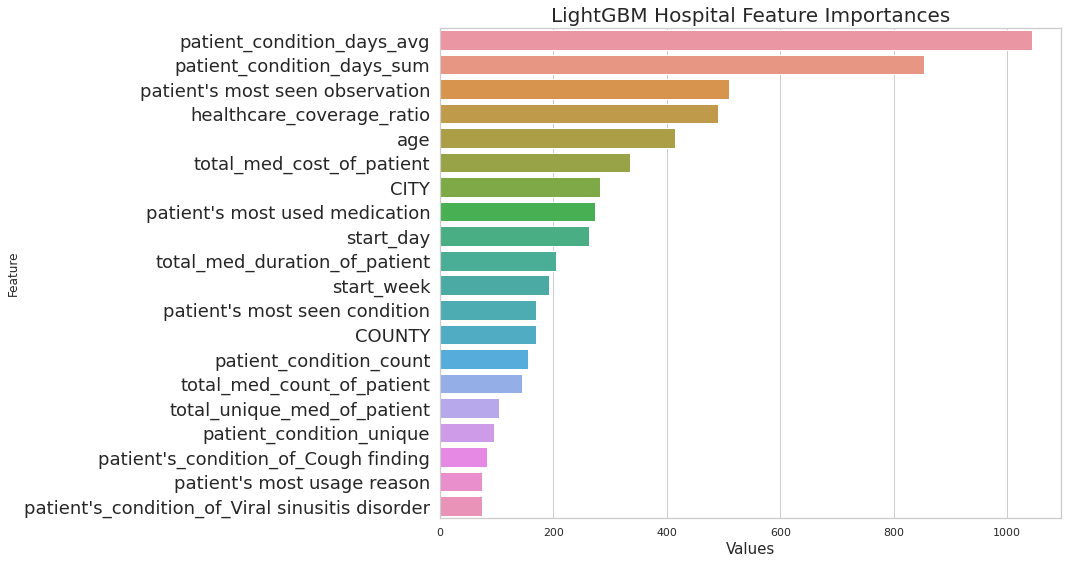

<Figure size 432x288 with 0 Axes>

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 8))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM Hospital Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

### FT - Transformer Models

In [3]:
#!pip install tensorflow_addons

In [4]:
#!pip install tabtransformertf


In [105]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [106]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [107]:
data = df.copy()
data = data.rename(columns = {"careplan_duration" : "duration"})
data = data.loc[data.duration > 0].reset_index(drop = True)

In [108]:
y = data['duration']
LABEL = "duration"

In [109]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [110]:
FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)

In [111]:
NUMERIC_FEATURES


['age',
 'healthcare_coverage_ratio',
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Sore throat symptom finding",
 "patient's_condition_of_Headache finding",
 "patient's_condition_of_Chill finding",
 "patient's_condition_of_Diabetes",
 'patient_condition_count',
 'patient_condition_unique',
 'patient_obs_count',
 'patient_obs_count_unique',
 'total_med_duration_of_patient',
 'total_med_cost_of_patient',
 'total_med_count_of_patient',
 'total_unique_med_of_patient',
 'used_unique_device_per_patient',
 'Mechanical ventilator (physical object)',
 'unique_immunizations',
 "patient's Digital Radiographycount",
 "patient's Ultrasoundcount",
 "patient's_different_bodysite_imaging_studies",
 

In [112]:
CATEGORICAL_FEATURES

["patient's most seen careplan",
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_Hemoglobin_Massvolume_in_Blood",
 "patient's_observation_of_Glucose_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's most seen observation",
 "patient's most used medication",
 "patient's most used device",
 "patient's most seen allergy"]

In [113]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [114]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [115]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [116]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [117]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 2

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/2
4/4 [==============================] - 10s 435ms/step - loss: 558.9702 - output_loss: 558.9702 - output_rmse: 23.6425 - val_loss: 419.4149 - val_output_loss: 419.4149 - val_output_rmse: 20.4796
Epoch 2/2
4/4 [==============================] - 0s 90ms/step - loss: 442.7591 - output_loss: 442.7591 - output_rmse: 21.0418 - val_loss: 364.0146 - val_output_loss: 364.0146 - val_output_rmse: 19.0792


In [118]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
4/4 [==============================] - 7s 326ms/step - loss: 638.3588 - output_loss: 638.3588 - output_rmse: 25.2658 - val_loss: 568.2167 - val_output_loss: 568.2167 - val_output_rmse: 23.8373
Epoch 2/10
4/4 [==============================] - 0s 52ms/step - loss: 598.2125 - output_loss: 598.2125 - output_rmse: 24.4584 - val_loss: 539.9363 - val_output_loss: 539.9363 - val_output_rmse: 23.2365
Epoch 3/10
4/4 [==============================] - 0s 51ms/step - loss: 570.3897 - output_loss: 570.3897 - output_rmse: 23.8828 - val_loss: 515.9826 - val_output_loss: 515.9826 - val_output_rmse: 22.7153
Epoch 4/10
4/4 [==============================] - 0s 50ms/step - loss: 543.9120 - output_loss: 543.9120 - output_rmse: 23.3219 - val_loss: 490.9682 - val_output_loss: 490.9682 - val_output_rmse: 22.1578
Epoch 5/10
4/4 [==============================] - 0s 49ms/step - loss: 516.7557 - output_loss: 516.7557 - output_rmse: 22.7323 - val_loss: 467.1979 - val_output_loss: 467.1979 - val_outpu

In [119]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 697ms/step


In [2]:
#pip install optuna

### Parameter Optimization for Transformer Models

In [121]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 50

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-22 21:30:07,512] A new study created in memory with name: no-name-90524676-4f4b-44f8-bcb4-eed3adfd0a69


Epoch 1/50
4/4 [==============================] - 6s 276ms/step - loss: 518.2049 - output_loss: 518.2049 - output_rmse: 22.7641 - val_loss: 262.8318 - val_output_loss: 262.8318 - val_output_rmse: 16.2121
Epoch 2/50
4/4 [==============================] - 0s 55ms/step - loss: 307.5331 - output_loss: 307.5331 - output_rmse: 17.5366 - val_loss: 190.4544 - val_output_loss: 190.4544 - val_output_rmse: 13.8005
Epoch 3/50
4/4 [==============================] - 0s 54ms/step - loss: 217.7898 - output_loss: 217.7898 - output_rmse: 14.7577 - val_loss: 150.8236 - val_output_loss: 150.8236 - val_output_rmse: 12.2810
Epoch 4/50
4/4 [==============================] - 0s 51ms/step - loss: 168.5471 - output_loss: 168.5471 - output_rmse: 12.9826 - val_loss: 123.4161 - val_output_loss: 123.4161 - val_output_rmse: 11.1093
Epoch 5/50
4/4 [==============================] - 0s 51ms/step - loss: 136.3007 - output_loss: 136.3007 - output_rmse: 11.6748 - val_loss: 104.0539 - val_output_loss: 104.0539 - val_outpu

[I 2023-01-22 21:30:22,415] Trial 0 finished with value: 6.421812287185358 and parameters: {'numerical_bins': 21, 'embedding_dim': 73, 'depth': 2, 'heads': 2, 'attn_dropout': 0.49539762146206334, 'ff_dropout': 0.25819741329814405}. Best is trial 0 with value: 6.421812287185358.


Epoch 1/50
4/4 [==============================] - 6s 249ms/step - loss: 651.8031 - output_loss: 651.8031 - output_rmse: 25.5304 - val_loss: 569.3811 - val_output_loss: 569.3811 - val_output_rmse: 23.8617
Epoch 2/50
4/4 [==============================] - 0s 40ms/step - loss: 588.7151 - output_loss: 588.7151 - output_rmse: 24.2635 - val_loss: 513.7326 - val_output_loss: 513.7326 - val_output_rmse: 22.6657
Epoch 3/50
4/4 [==============================] - 0s 41ms/step - loss: 549.6535 - output_loss: 549.6535 - output_rmse: 23.4447 - val_loss: 485.9323 - val_output_loss: 485.9323 - val_output_rmse: 22.0439
Epoch 4/50
4/4 [==============================] - 0s 39ms/step - loss: 523.7391 - output_loss: 523.7391 - output_rmse: 22.8853 - val_loss: 462.7118 - val_output_loss: 462.7118 - val_output_rmse: 21.5107
Epoch 5/50
4/4 [==============================] - 0s 38ms/step - loss: 499.4138 - output_loss: 499.4138 - output_rmse: 22.3476 - val_loss: 442.1296 - val_output_loss: 442.1296 - val_outpu

[I 2023-01-22 21:30:37,600] Trial 1 finished with value: 6.433745270205583 and parameters: {'numerical_bins': 47, 'embedding_dim': 23, 'depth': 2, 'heads': 2, 'attn_dropout': 0.17157709210730482, 'ff_dropout': 0.3882565978562026}. Best is trial 0 with value: 6.421812287185358.


Epoch 1/50
4/4 [==============================] - 11s 585ms/step - loss: 469.5345 - output_loss: 469.5345 - output_rmse: 21.6687 - val_loss: 249.3959 - val_output_loss: 249.3959 - val_output_rmse: 15.7923
Epoch 2/50
4/4 [==============================] - 1s 205ms/step - loss: 262.5569 - output_loss: 262.5569 - output_rmse: 16.2036 - val_loss: 206.7898 - val_output_loss: 206.7898 - val_output_rmse: 14.3802
Epoch 3/50
4/4 [==============================] - 1s 214ms/step - loss: 218.6833 - output_loss: 218.6833 - output_rmse: 14.7879 - val_loss: 185.7486 - val_output_loss: 185.7486 - val_output_rmse: 13.6290
Epoch 4/50
4/4 [==============================] - 1s 215ms/step - loss: 193.7981 - output_loss: 193.7981 - output_rmse: 13.9211 - val_loss: 164.6255 - val_output_loss: 164.6255 - val_output_rmse: 12.8306
Epoch 5/50
4/4 [==============================] - 1s 215ms/step - loss: 170.9635 - output_loss: 170.9635 - output_rmse: 13.0753 - val_loss: 144.6796 - val_output_loss: 144.6796 - val_

1/1 [==============================] - 1s 1s/step


[I 2023-01-22 21:31:20,558] Trial 2 finished with value: 6.424723116070725 and parameters: {'numerical_bins': 100, 'embedding_dim': 88, 'depth': 6, 'heads': 6, 'attn_dropout': 0.3532852728666083, 'ff_dropout': 0.26968935655583876}. Best is trial 0 with value: 6.421812287185358.


Epoch 1/50
4/4 [==============================] - 9s 446ms/step - loss: 619.0862 - output_loss: 619.0862 - output_rmse: 24.8814 - val_loss: 470.3382 - val_output_loss: 470.3382 - val_output_rmse: 21.6873
Epoch 2/50
4/4 [==============================] - 0s 113ms/step - loss: 504.4423 - output_loss: 504.4423 - output_rmse: 22.4598 - val_loss: 435.7992 - val_output_loss: 435.7992 - val_output_rmse: 20.8758
Epoch 3/50
4/4 [==============================] - 0s 114ms/step - loss: 462.2204 - output_loss: 462.2204 - output_rmse: 21.4993 - val_loss: 416.0894 - val_output_loss: 416.0894 - val_output_rmse: 20.3983
Epoch 4/50
4/4 [==============================] - 0s 114ms/step - loss: 439.0147 - output_loss: 439.0147 - output_rmse: 20.9527 - val_loss: 401.8105 - val_output_loss: 401.8105 - val_output_rmse: 20.0452
Epoch 5/50
4/4 [==============================] - 0s 115ms/step - loss: 422.8501 - output_loss: 422.8501 - output_rmse: 20.5633 - val_loss: 390.2203 - val_output_loss: 390.2203 - val_o

1/1 [==============================] - 1s 960ms/step


[I 2023-01-22 21:31:54,931] Trial 3 finished with value: 6.422421165977356 and parameters: {'numerical_bins': 194, 'embedding_dim': 36, 'depth': 5, 'heads': 8, 'attn_dropout': 0.01094703995037638, 'ff_dropout': 0.22798254704592197}. Best is trial 0 with value: 6.421812287185358.


Epoch 1/50
4/4 [==============================] - 8s 408ms/step - loss: 553.9282 - output_loss: 553.9282 - output_rmse: 23.5357 - val_loss: 323.6078 - val_output_loss: 323.6078 - val_output_rmse: 17.9891
Epoch 2/50
4/4 [==============================] - 0s 111ms/step - loss: 333.4320 - output_loss: 333.4320 - output_rmse: 18.2601 - val_loss: 254.9010 - val_output_loss: 254.9010 - val_output_rmse: 15.9656
Epoch 3/50
4/4 [==============================] - 0s 114ms/step - loss: 270.6748 - output_loss: 270.6748 - output_rmse: 16.4522 - val_loss: 231.5231 - val_output_loss: 231.5231 - val_output_rmse: 15.2159
Epoch 4/50
4/4 [==============================] - 0s 111ms/step - loss: 242.7719 - output_loss: 242.7719 - output_rmse: 15.5811 - val_loss: 210.5710 - val_output_loss: 210.5710 - val_output_rmse: 14.5111
Epoch 5/50
4/4 [==============================] - 0s 111ms/step - loss: 220.3152 - output_loss: 220.3152 - output_rmse: 14.8430 - val_loss: 191.6768 - val_output_loss: 191.6768 - val_o

[I 2023-01-22 21:32:23,615] Trial 4 finished with value: 6.421057694163407 and parameters: {'numerical_bins': 91, 'embedding_dim': 82, 'depth': 4, 'heads': 4, 'attn_dropout': 0.3802585592855217, 'ff_dropout': 0.15937855935302586}. Best is trial 4 with value: 6.421057694163407.


Number of finished trials: 5
Best trial: {'numerical_bins': 91, 'embedding_dim': 82, 'depth': 4, 'heads': 4, 'attn_dropout': 0.3802585592855217, 'ff_dropout': 0.15937855935302586}


In [122]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=72,
    embedding_dim=74,
    depth=2,
    heads=6,
    attn_dropout= 0.1108,
    ff_dropout= 0.1498,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 30

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/30
4/4 [==============================] - 6s 302ms/step - loss: 645.1761 - output_loss: 645.1761 - output_rmse: 25.4003 - val_loss: 540.7548 - val_output_loss: 540.7548 - val_output_rmse: 23.2541
Epoch 2/30
4/4 [==============================] - 0s 75ms/step - loss: 552.6025 - output_loss: 552.6025 - output_rmse: 23.5075 - val_loss: 474.9448 - val_output_loss: 474.9448 - val_output_rmse: 21.7932
Epoch 3/30
4/4 [==============================] - 0s 75ms/step - loss: 494.9922 - output_loss: 494.9922 - output_rmse: 22.2484 - val_loss: 441.9982 - val_output_loss: 441.9982 - val_output_rmse: 21.0238
Epoch 4/30
4/4 [==============================] - 0s 77ms/step - loss: 460.0175 - output_loss: 460.0175 - output_rmse: 21.4480 - val_loss: 406.2558 - val_output_loss: 406.2558 - val_output_rmse: 20.1558
Epoch 5/30
4/4 [==============================] - 0s 80ms/step - loss: 417.5949 - output_loss: 417.5949 - output_rmse: 20.4351 - val_loss: 367.0992 - val_output_loss: 367.0992 - val_outpu

In [123]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 1s 618ms/step


### Periodic Encoding FT Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

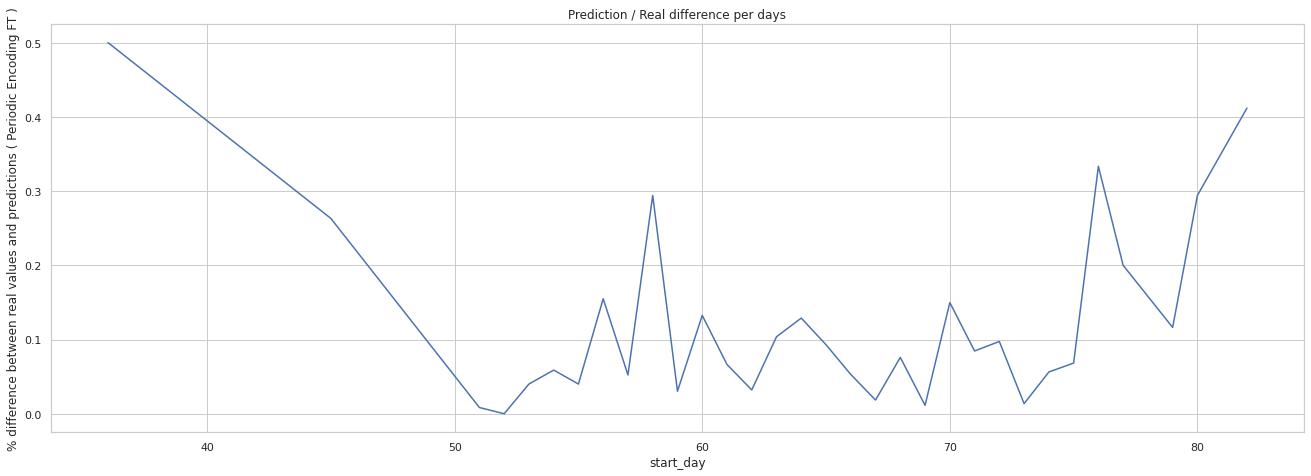

In [124]:
test_copy = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["careplan_duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

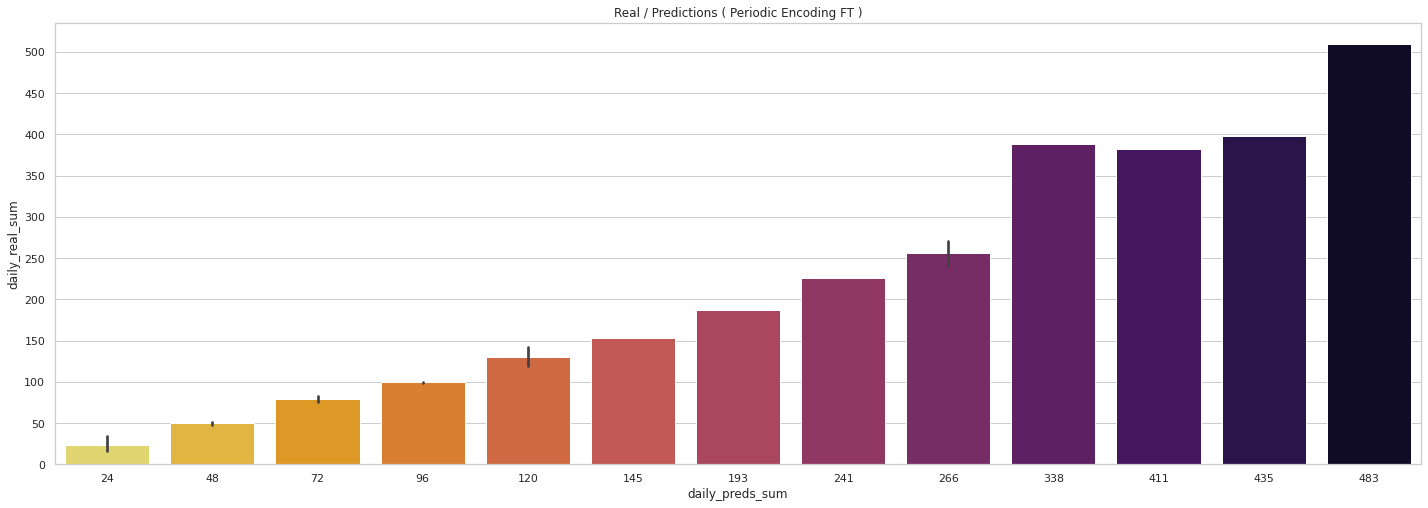

In [125]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

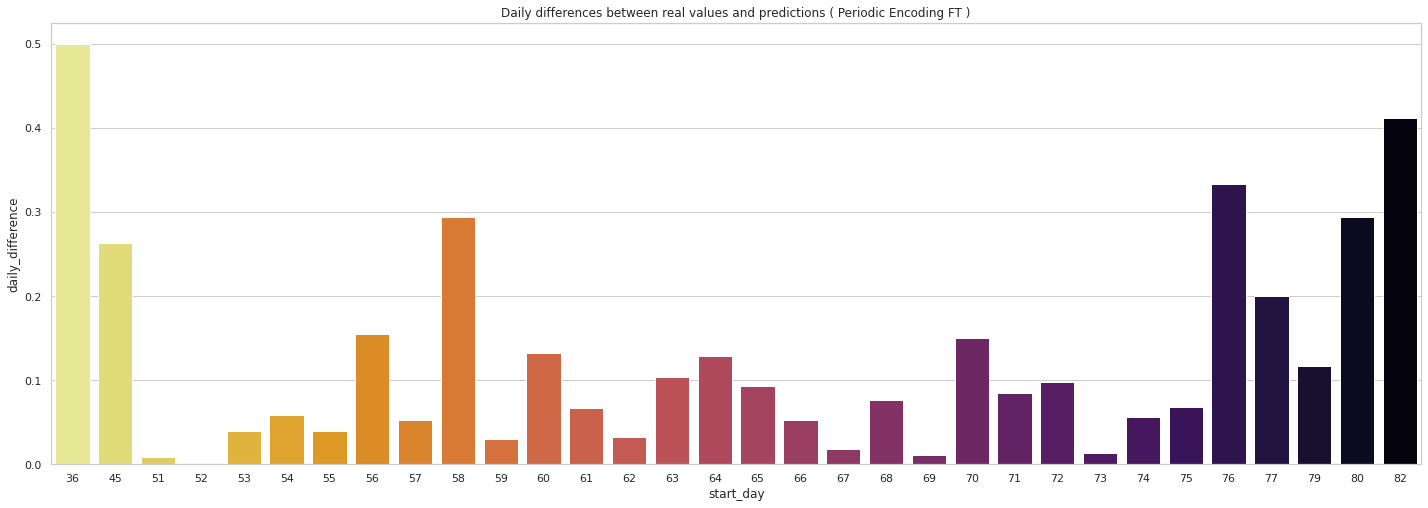

In [126]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

### Linear Encoding Parameter Optimization

In [127]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 50

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-22 21:32:42,198] A new study created in memory with name: no-name-ed5f9d1a-eb8e-4548-b227-6a50eccf2055


Epoch 1/50
4/4 [==============================] - 7s 344ms/step - loss: 611.8900 - output_loss: 611.8900 - output_rmse: 24.7364 - val_loss: 407.4698 - val_output_loss: 407.4698 - val_output_rmse: 20.1859
Epoch 2/50
4/4 [==============================] - 0s 82ms/step - loss: 425.5682 - output_loss: 425.5682 - output_rmse: 20.6293 - val_loss: 350.2390 - val_output_loss: 350.2390 - val_output_rmse: 18.7147
Epoch 3/50
4/4 [==============================] - 0s 82ms/step - loss: 370.0092 - output_loss: 370.0092 - output_rmse: 19.2356 - val_loss: 327.5597 - val_output_loss: 327.5597 - val_output_rmse: 18.0986
Epoch 4/50
4/4 [==============================] - 0s 81ms/step - loss: 345.0224 - output_loss: 345.0224 - output_rmse: 18.5748 - val_loss: 311.6505 - val_output_loss: 311.6505 - val_output_rmse: 17.6536
Epoch 5/50
4/4 [==============================] - 0s 81ms/step - loss: 326.5680 - output_loss: 326.5680 - output_rmse: 18.0712 - val_loss: 295.1805 - val_output_loss: 295.1805 - val_outpu

[I 2023-01-22 21:33:07,489] Trial 0 finished with value: 6.441254312064397 and parameters: {'numerical_bins': 27, 'embedding_dim': 55, 'depth': 3, 'heads': 6, 'attn_dropout': 0.26779137648873796, 'ff_dropout': 0.15269322208310188}. Best is trial 0 with value: 6.441254312064397.


Epoch 1/50
4/4 [==============================] - 11s 546ms/step - loss: 509.9770 - output_loss: 509.9770 - output_rmse: 22.5827 - val_loss: 223.5098 - val_output_loss: 223.5098 - val_output_rmse: 14.9502
Epoch 2/50
4/4 [==============================] - 1s 169ms/step - loss: 240.8677 - output_loss: 240.8677 - output_rmse: 15.5199 - val_loss: 168.1477 - val_output_loss: 168.1477 - val_output_rmse: 12.9672
Epoch 3/50
4/4 [==============================] - 1s 170ms/step - loss: 180.7557 - output_loss: 180.7557 - output_rmse: 13.4445 - val_loss: 145.1242 - val_output_loss: 145.1242 - val_output_rmse: 12.0468
Epoch 4/50
4/4 [==============================] - 1s 170ms/step - loss: 155.3212 - output_loss: 155.3212 - output_rmse: 12.4628 - val_loss: 128.4250 - val_output_loss: 128.4250 - val_output_rmse: 11.3325
Epoch 5/50
4/4 [==============================] - 1s 173ms/step - loss: 136.0016 - output_loss: 136.0016 - output_rmse: 11.6620 - val_loss: 112.4184 - val_output_loss: 112.4184 - val_

[I 2023-01-22 21:33:44,617] Trial 1 finished with value: 6.4204545606857275 and parameters: {'numerical_bins': 93, 'embedding_dim': 68, 'depth': 6, 'heads': 6, 'attn_dropout': 0.39321246055743103, 'ff_dropout': 0.3624688580540231}. Best is trial 1 with value: 6.4204545606857275.


Epoch 1/50
4/4 [==============================] - 7s 343ms/step - loss: 582.9933 - output_loss: 582.9933 - output_rmse: 24.1453 - val_loss: 407.5897 - val_output_loss: 407.5897 - val_output_rmse: 20.1889
Epoch 2/50
4/4 [==============================] - 0s 83ms/step - loss: 416.8365 - output_loss: 416.8365 - output_rmse: 20.4166 - val_loss: 319.3467 - val_output_loss: 319.3467 - val_output_rmse: 17.8703
Epoch 3/50
4/4 [==============================] - 0s 83ms/step - loss: 335.6269 - output_loss: 335.6269 - output_rmse: 18.3201 - val_loss: 277.7620 - val_output_loss: 277.7620 - val_output_rmse: 16.6662
Epoch 4/50
4/4 [==============================] - 0s 84ms/step - loss: 293.4989 - output_loss: 293.4989 - output_rmse: 17.1318 - val_loss: 250.9138 - val_output_loss: 250.9138 - val_output_rmse: 15.8403
Epoch 5/50
4/4 [==============================] - 0s 84ms/step - loss: 262.3036 - output_loss: 262.3036 - output_rmse: 16.1958 - val_loss: 224.1267 - val_output_loss: 224.1267 - val_outpu

[I 2023-01-22 21:34:07,938] Trial 2 finished with value: 6.420901501320099 and parameters: {'numerical_bins': 21, 'embedding_dim': 57, 'depth': 3, 'heads': 6, 'attn_dropout': 0.2901423449175695, 'ff_dropout': 0.2515044606709141}. Best is trial 1 with value: 6.4204545606857275.


Epoch 1/50
4/4 [==============================] - 10s 448ms/step - loss: 580.0521 - output_loss: 580.0521 - output_rmse: 24.0843 - val_loss: 485.0469 - val_output_loss: 485.0469 - val_output_rmse: 22.0238
Epoch 2/50
4/4 [==============================] - 0s 72ms/step - loss: 508.7912 - output_loss: 508.7912 - output_rmse: 22.5564 - val_loss: 453.2496 - val_output_loss: 453.2496 - val_output_rmse: 21.2897
Epoch 3/50
4/4 [==============================] - 0s 72ms/step - loss: 477.3828 - output_loss: 477.3828 - output_rmse: 21.8491 - val_loss: 432.5004 - val_output_loss: 432.5004 - val_output_rmse: 20.7966
Epoch 4/50
4/4 [==============================] - 0s 72ms/step - loss: 456.4933 - output_loss: 456.4933 - output_rmse: 21.3657 - val_loss: 416.5137 - val_output_loss: 416.5137 - val_output_rmse: 20.4087
Epoch 5/50
4/4 [==============================] - 0s 71ms/step - loss: 439.2500 - output_loss: 439.2500 - output_rmse: 20.9583 - val_loss: 403.3613 - val_output_loss: 403.3613 - val_outp

[I 2023-01-22 21:34:35,268] Trial 3 finished with value: 6.425262789682377 and parameters: {'numerical_bins': 117, 'embedding_dim': 22, 'depth': 6, 'heads': 4, 'attn_dropout': 0.22524378261005118, 'ff_dropout': 0.25599274801055966}. Best is trial 1 with value: 6.4204545606857275.


Epoch 1/50
4/4 [==============================] - 6s 278ms/step - loss: 639.6202 - output_loss: 639.6202 - output_rmse: 25.2907 - val_loss: 507.0400 - val_output_loss: 507.0400 - val_output_rmse: 22.5175
Epoch 2/50
4/4 [==============================] - 0s 61ms/step - loss: 540.1890 - output_loss: 540.1890 - output_rmse: 23.2420 - val_loss: 453.3294 - val_output_loss: 453.3294 - val_output_rmse: 21.2915
Epoch 3/50
4/4 [==============================] - 0s 53ms/step - loss: 486.4799 - output_loss: 486.4799 - output_rmse: 22.0563 - val_loss: 416.4504 - val_output_loss: 416.4504 - val_output_rmse: 20.4071
Epoch 4/50
4/4 [==============================] - 0s 51ms/step - loss: 445.0191 - output_loss: 445.0191 - output_rmse: 21.0955 - val_loss: 394.4506 - val_output_loss: 394.4506 - val_output_rmse: 19.8608
Epoch 5/50
4/4 [==============================] - 0s 52ms/step - loss: 417.9413 - output_loss: 417.9413 - output_rmse: 20.4436 - val_loss: 380.3636 - val_output_loss: 380.3636 - val_outpu

[I 2023-01-22 21:34:53,607] Trial 4 finished with value: 6.450712305190888 and parameters: {'numerical_bins': 68, 'embedding_dim': 30, 'depth': 2, 'heads': 8, 'attn_dropout': 0.14203807352249503, 'ff_dropout': 0.3475546263681083}. Best is trial 1 with value: 6.4204545606857275.


Number of finished trials: 5
Best trial: {'numerical_bins': 93, 'embedding_dim': 68, 'depth': 6, 'heads': 6, 'attn_dropout': 0.39321246055743103, 'ff_dropout': 0.3624688580540231}


In [128]:
study.best_trial.params

{'numerical_bins': 93,
 'embedding_dim': 68,
 'depth': 6,
 'heads': 6,
 'attn_dropout': 0.39321246055743103,
 'ff_dropout': 0.3624688580540231}

Best trial: {'numerical_bins': 137, 'embedding_dim': 90, 'depth': 4, 'heads': 3, 'attn_dropout': 0.2569205055586698, 'ff_dropout': 0.11918342936607934}

In [129]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=25,
    embedding_dim=57,
    depth=1,
    heads=8,
    attn_dropout= 0.3773,
    ff_dropout= 0.1355,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 30

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/30
4/4 [==============================] - 5s 227ms/step - loss: 480.5070 - output_loss: 480.5070 - output_rmse: 21.9205 - val_loss: 322.1678 - val_output_loss: 322.1678 - val_output_rmse: 17.9490
Epoch 2/30
4/4 [==============================] - 0s 51ms/step - loss: 333.0545 - output_loss: 333.0545 - output_rmse: 18.2498 - val_loss: 248.8068 - val_output_loss: 248.8068 - val_output_rmse: 15.7736
Epoch 3/30
4/4 [==============================] - 0s 46ms/step - loss: 267.9935 - output_loss: 267.9935 - output_rmse: 16.3705 - val_loss: 200.1161 - val_output_loss: 200.1161 - val_output_rmse: 14.1462
Epoch 4/30
4/4 [==============================] - 0s 45ms/step - loss: 222.8546 - output_loss: 222.8546 - output_rmse: 14.9283 - val_loss: 171.3072 - val_output_loss: 171.3072 - val_output_rmse: 13.0884
Epoch 5/30
4/4 [==============================] - 0s 45ms/step - loss: 191.1616 - output_loss: 191.1616 - output_rmse: 13.8261 - val_loss: 149.5310 - val_output_loss: 149.5310 - val_outpu

In [130]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 0s 461ms/step


In [131]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 16ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

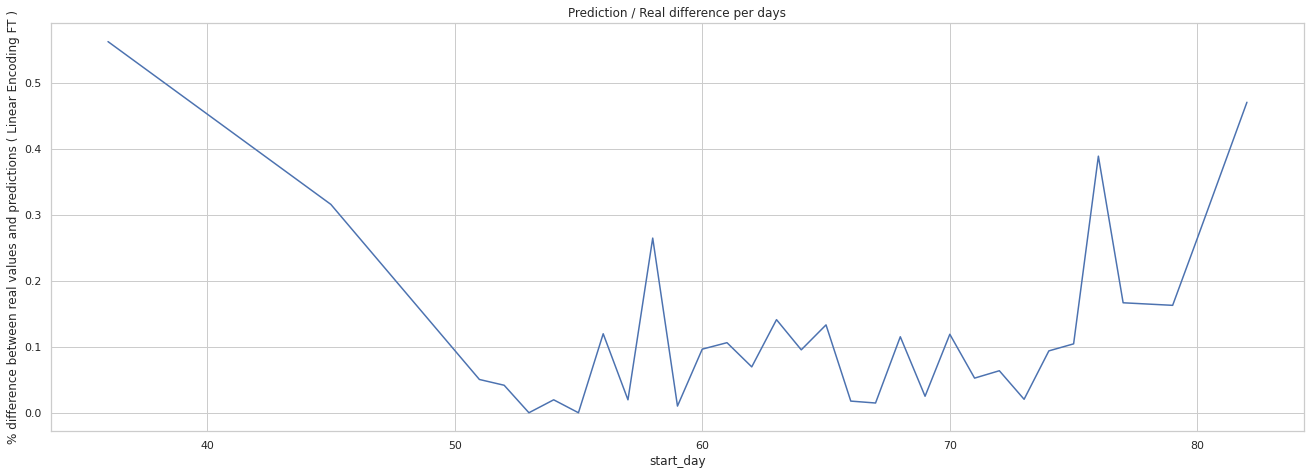

In [132]:
test_copy = df.loc[(df.dataset == "test") & (df.careplan_duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["careplan_duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

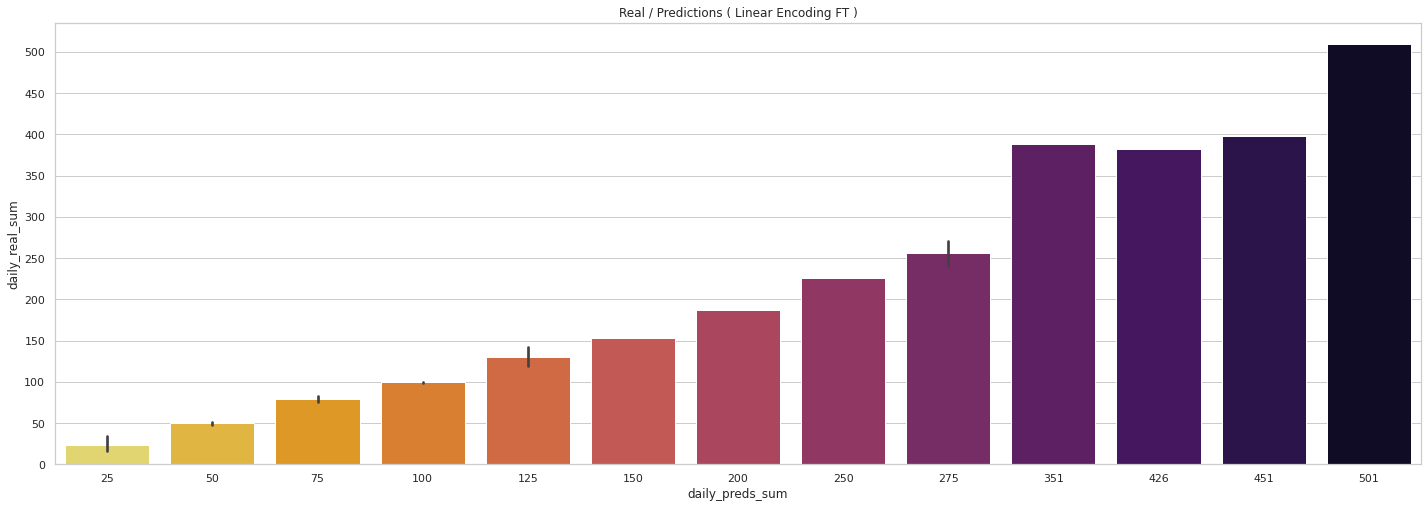

In [133]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

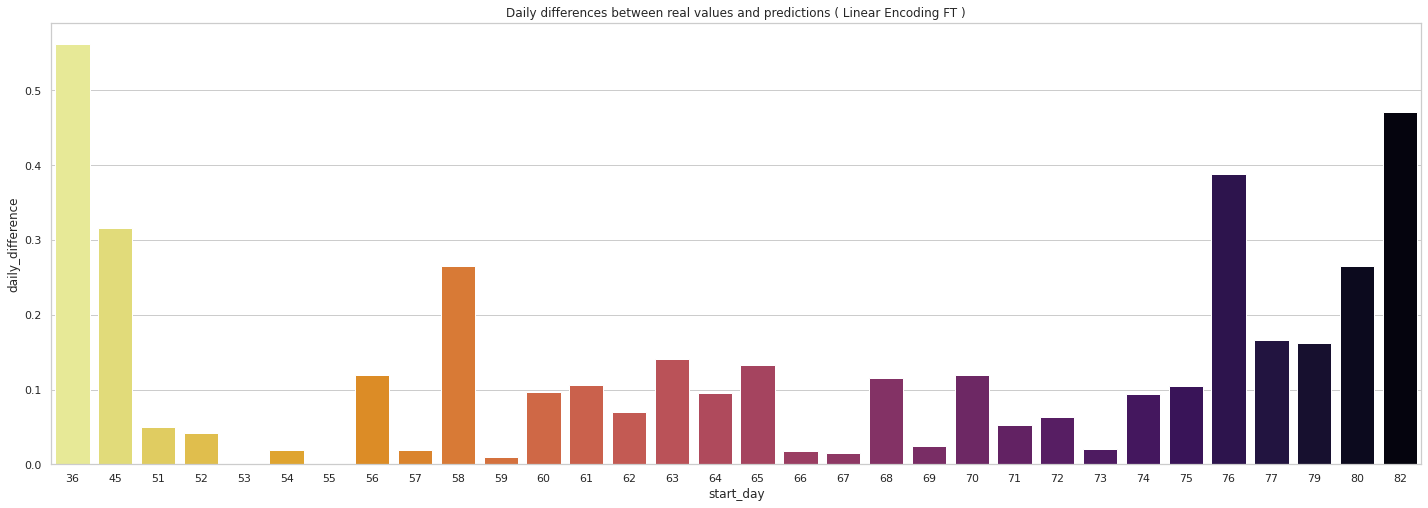

In [134]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

### Our results were like this :

In [135]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-7.841826,17.979887,19.091183
Transformer - Periodic Encoding,-7.841826,18.611704,19.687979
LightGBM,0.733173,1.908099,3.316473


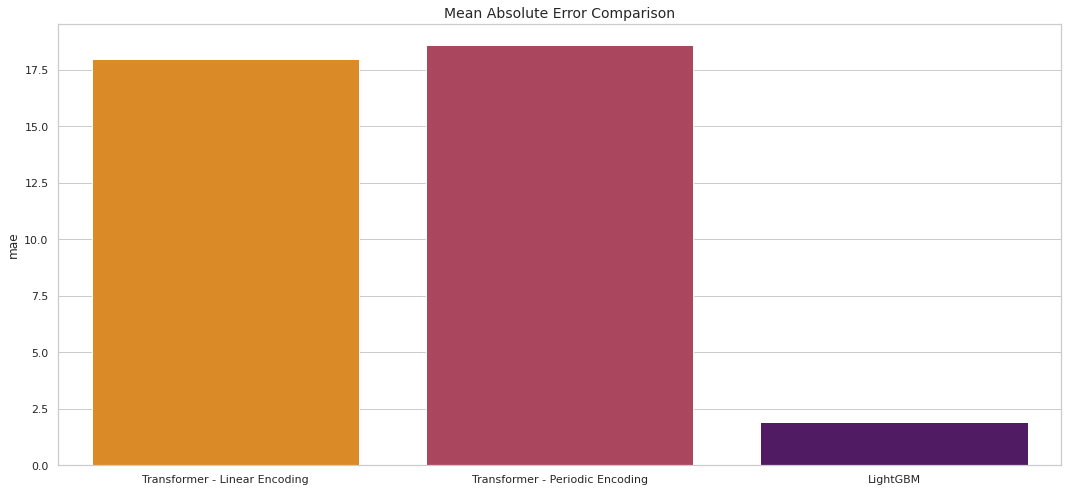

In [136]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


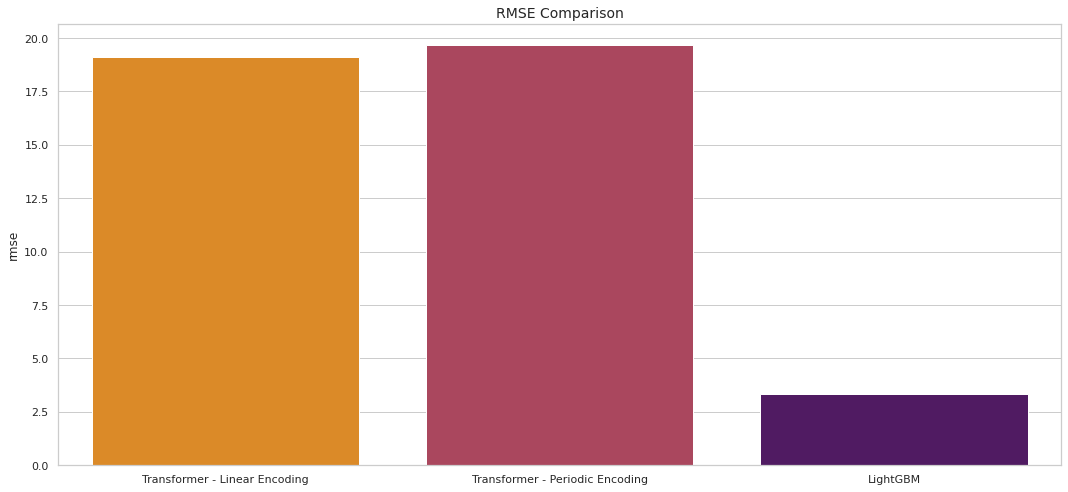

In [137]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


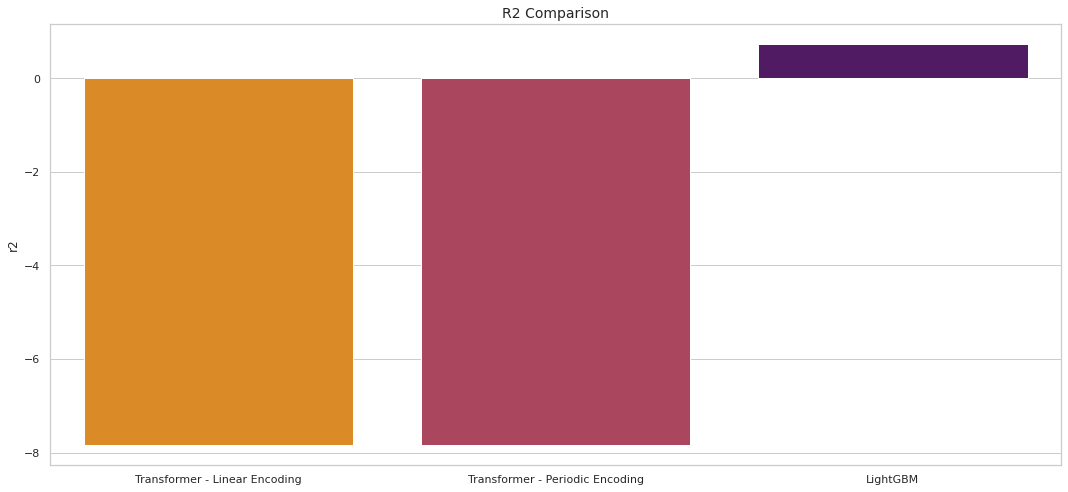

In [138]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [139]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.007450,5.534203,6.444268
Transformer - Periodic Encoding TUNED,-0.003155,5.490492,6.430518
LightGBM TUNED,0.688869,1.988491,3.581238


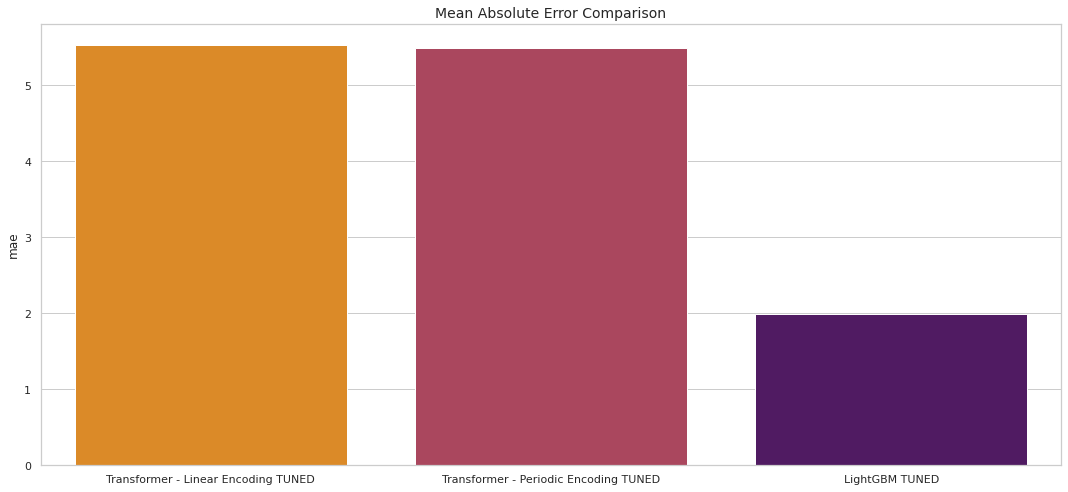

In [140]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


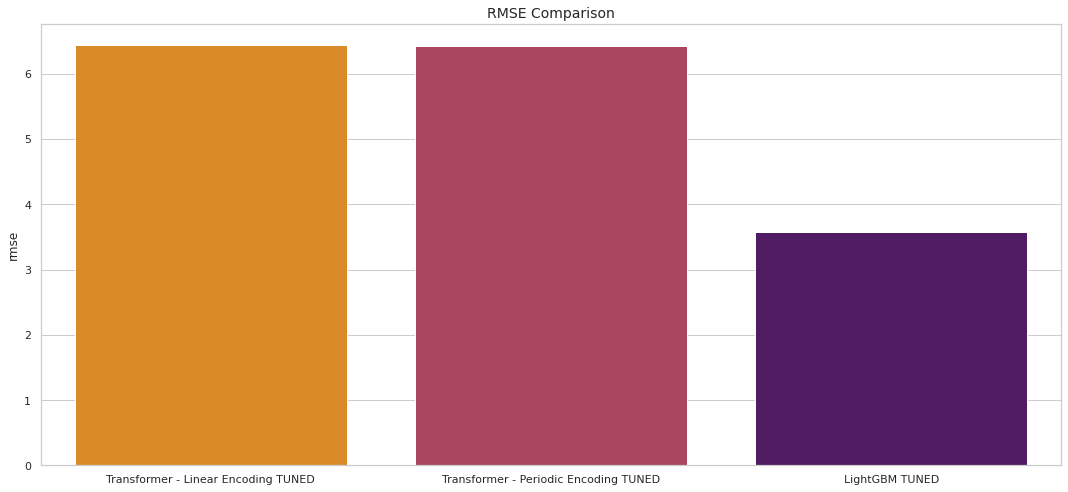

In [141]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


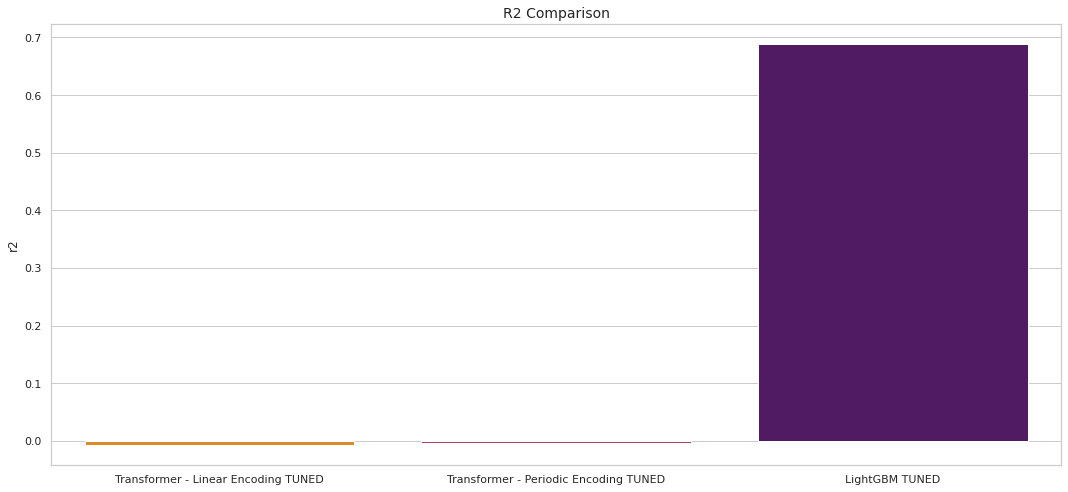

In [142]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
